## **Import libary**

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from skimage import feature


# **remapping the data so that it's ONLY 2 classes**

In [2]:
!mkdir -p /kaggle/working/train/fresh
!mkdir -p /kaggle/working/train/rotten
!mkdir -p /kaggle/working/test/fresh
!mkdir -p /kaggle/working/test/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshapples/* /kaggle/working/train/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshbanana/* /kaggle/working/train/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshoranges/* /kaggle/working/train/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenapples/* /kaggle/working/train/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenbanana/* /kaggle/working/train/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenoranges/* /kaggle/working/train/rotten

In [3]:
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshapples/* /kaggle/working/test/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshbanana/* /kaggle/working/test/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshoranges/* /kaggle/working/test/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenapples/* /kaggle/working/test/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenbanana/* /kaggle/working/test/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenoranges/* /kaggle/working/test/rotten

## **Loading Data**

In [4]:

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    labels = []
    for class_label in os.listdir(folder):
        class_path = os.path.join(folder, class_label)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path,3)
                img = cv2.resize(img, target_size)  # Resize the image
                images.append(img)
                labels.append(class_label)
    return images, np.array(labels)

In [5]:
TRAIN_PATH = '/kaggle/working/train'
TEST_PATH = '/kaggle/working/test'

X_train_images, y_train = load_and_resize_images_from_folder(TRAIN_PATH)
X_test_images, y_test = load_and_resize_images_from_folder(TEST_PATH)

# **Visualization Dataset**

In [6]:
import random
#desplaying the train data
random_indices = random.sample(range(len(X_train_images)), 15)

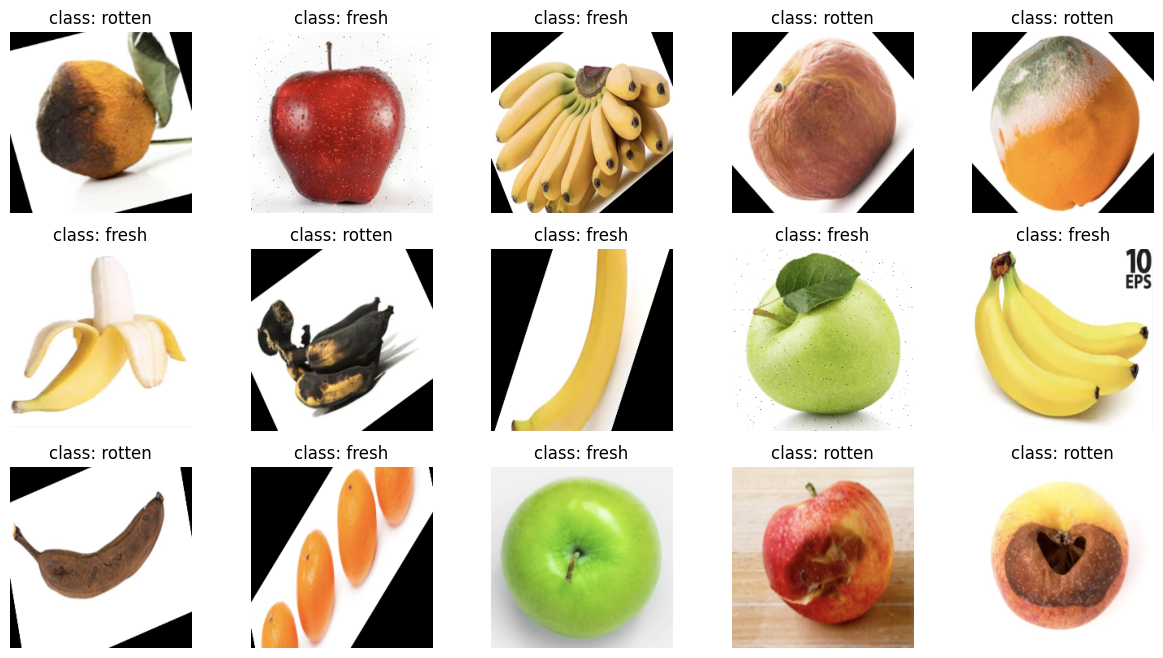

In [7]:
# Plot the images
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices, 1):
    plt.subplot(3,5, i)
    plt.imshow(cv2.cvtColor(X_train_images[index], cv2.COLOR_BGR2RGB))
    plt.title(f'class: {y_train[index]}')
    plt.axis('off')

plt.show()

## **Convert Data to Features(USE HISTOGRAM)**

In [8]:
def compute_histogram_img(img_list, bins=(8, 8, 8)):
    img_features = []
    for img in img_list:
        # Convert Color to BGR
        bgr_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Calculate histogram color
        hist = cv2.calcHist([bgr_img], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        # Normalize Histogram
        hist = cv2.normalize(hist, hist).flatten()
        img_features.append(hist)
    return np.array(img_features)



In [9]:
#Computer Features
X_train=compute_histogram_img(X_train_images)
X_test=compute_histogram_img(X_test_images)
y_train=np.where(y_train=='fresh',1,0)
y_test=np.where(y_test=='fresh',1,0)

In [10]:
# Split the training data into training and validation 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [11]:
print(X_train.shape) 
print(X_val.shape)
y_train


(7630, 512)
(3271, 512)


array([0, 0, 0, ..., 0, 1, 0])

## **Train SVM**

In [12]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)
random_forest.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [13]:
import joblib
save_path='/kaggle/working/random_forest_models.dat'
joblib.dump(random_forest,save_path )
print(f'Model saved : {save_path}')

Model saved : /kaggle/working/random_forest_models.dat


## **Evaluation**

### **1.Validation Set**

In [14]:
from collections import Counter
y_val_preds=[]
for i in X_val:
    y_val_pred=random_forest.predict(i.reshape(1,-1))
    y_val_preds.append(y_val_pred[0])
print(Counter(y_val_preds))

Counter({0: 1830, 1: 1441})


In [15]:
from sklearn.metrics import classification_report
print(f"Classification report for classifier {random_forest}:\n"
      f"{classification_report(y_val, y_val_preds)}")

Classification report for classifier RandomForestClassifier(random_state=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1831
           1       1.00      1.00      1.00      1440

    accuracy                           1.00      3271
   macro avg       1.00      1.00      1.00      3271
weighted avg       1.00      1.00      1.00      3271



In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: "+str(accuracy_score(y_val, y_val_preds)))
print("Precision: "+str(precision_score(y_val, y_val_preds)))
print("Recall: "+str(recall_score(y_val, y_val_preds)))
print("F1-score: "+str(f1_score(y_val, y_val_preds)))

Accuracy: 0.9990828492815653
Precision: 0.9986120749479528
Recall: 0.9993055555555556
F1-score: 0.998958694897605


### **2.Test set**

In [17]:
y_test_preds=[]
for i in X_test:
    y_test_pred=random_forest.predict(i.reshape(1,-1))
    y_test_preds.append(y_test_pred[0])
print(Counter(y_test_preds))

Counter({0: 1531, 1: 1167})


In [18]:
from sklearn.metrics import classification_report
print(f"Classification report for classifier {random_forest}:\n"
      f"{classification_report(y_test, y_test_preds)}")

Classification report for classifier RandomForestClassifier(random_state=0):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1534
           1       1.00      1.00      1.00      1164

    accuracy                           1.00      2698
   macro avg       1.00      1.00      1.00      2698
weighted avg       1.00      1.00      1.00      2698



In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: "+str(accuracy_score(y_test, y_test_preds)))
print("Precision: "+str(precision_score(y_test, y_test_preds)))
print("Recall: "+str(recall_score(y_test, y_test_preds)))
print("F1-score: "+str(f1_score(y_test, y_test_preds)))

Accuracy: 0.9988880652335063
Precision: 0.9974293059125964
Recall: 1.0
F1-score: 0.9987129987129987


## Test Image From Internet

In [20]:
image_paths='/kaggle/input/test-data-2'
name_fruits=os.listdir(image_paths)
name_fruits

['th.jpg',
 'thuc-pham-nao-bi-moc-van-co-the-an-3.jpg',
 'th (1).jpg',
 'hinh-anh-qua-tao.jpg']

In [21]:
def classify_image(image_path,model_path):
  image = cv2.imread(image_path)
  image = cv2.resize(image,(224,224))
  image_feature=compute_histogram_img([image])
  model = joblib.load(model_path)
  pred = model.predict(image_feature.reshape(1,-1))

  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title(f'Predict:{pred}')
  plt.axis('off')
  plt.show()
  return pred


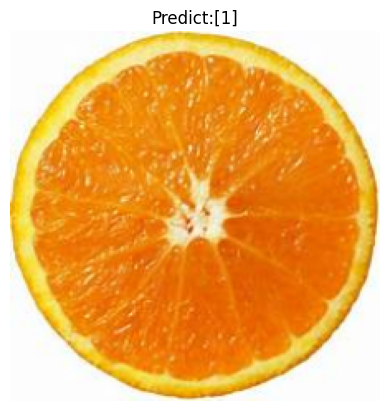

array([1])

In [22]:
fruits_path=[os.path.join(image_paths,i) for i in name_fruits]
model_path='/kaggle/working/random_forest_models.dat'
classify_image(fruits_path[0],model_path)

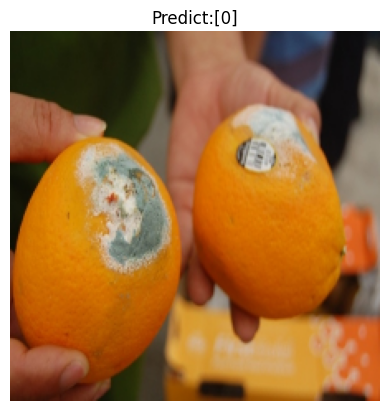

array([0])

In [23]:
#Predict is uncorrect maybe the image is not real.The photo is edited its color before uploading it online
fruits_path=[os.path.join(image_paths,i) for i in name_fruits]
model_path='/kaggle/working/random_forest_models.dat'
classify_image(fruits_path[1],model_path)

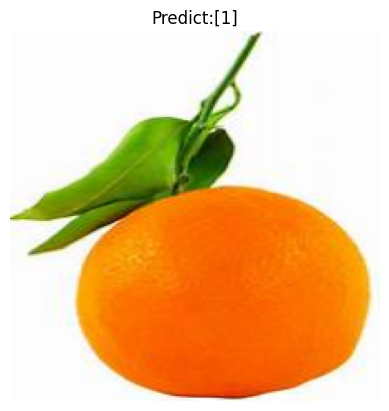

array([1])

In [24]:
fruits_path=[os.path.join(image_paths,i) for i in name_fruits]
model_path='/kaggle/working/random_forest_models.dat'
classify_image(fruits_path[2],model_path)

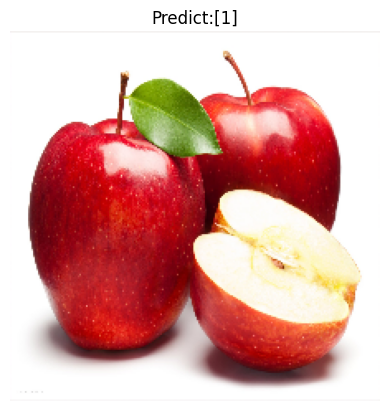

array([1])

In [25]:
fruits_path=[os.path.join(image_paths,i) for i in name_fruits]
model_path='/kaggle/working/random_forest_models.dat'
classify_image(fruits_path[3],model_path)

In [26]:
print(fruits_path)

['/kaggle/input/test-data-2/th.jpg', '/kaggle/input/test-data-2/thuc-pham-nao-bi-moc-van-co-the-an-3.jpg', '/kaggle/input/test-data-2/th (1).jpg', '/kaggle/input/test-data-2/hinh-anh-qua-tao.jpg']
